In [310]:
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import random

In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from collections import Counter
from spellchecker import SpellChecker

In [153]:
from lxml import html
import requests # modules for scraping html data from nltk page

In [3]:
import functions as van

In [4]:
# create the ls of ls as dataset
salientWords = van.readData("salientWords.txt")

# check to see if ls is same len after reading in data from doc
len(salientWords) == 3101

False

In [5]:
# document is not same length. extra item was thrown in. pop this item to remove it from list
salientWords.pop(3101)

['']

In [6]:
# check len again
len(salientWords) == 3101

True

# Word Frequency

In [88]:
# although we already put this through a dict above, I would rather use lists
allSalientWords = []

for sentIndex, sent in enumerate(salientWords):
    for wordIndex, word in enumerate(sent):
        allSalientWords.append(word)

len(allSalientWords)
("van" in allSalientWords) # so the word van is in salient words, so it got lost somewhere in the next two cells

True

In [354]:
allSalientWordsArr = uniqueArr(allSalientWords)
allSalientWordsDf = uniqueDf(allSalientWordsArr)
allSalientWordsDf.head(15) # so if i just let it chill like this it's all good

,token,indexFirstTokenOccur,frequency
3211,like,376,211
5866,van,280,163
429,back,262,159
4668,said,29,158
5592,time,64,157
3802,one,32,144
6120,would,193,137
4588,road,551,129
2688,home,67,122
3194,life,127,121


In [100]:
altAxis = allSalientWordsArr.transpose()


posTuples = nltk.pos_tag(altAxis[0])
posLs = []

for i in range(len(posTuples)):
    tup = posTuples[i]
    pos = tup[1]
    posLs.append(pos)
#posLs

posArr = np.array([posLs])

In [417]:
if len(allSalientWordsArr) == len(posLs):
    final = np.hstack([allSalientWordsArr, posArr.T])
else:
    print("no")

In [433]:
finalDf = pd.DataFrame(final, columns = ["word", "index", "frequency", "type"])
finalDf.loc[(finalDf["word"] == "van"), "type"] = "NN" # turn van into a noun
finalDf.loc[(finalDf["word"] == "get"), "type"] = "V" # turn get into a verb

In [439]:
def plotMaxType(fullDf, filterCriteria, xLabel, yLabel, title, num = 10, filterCol = "type", wordCol = "word", yAxis = "frequency"):
    df = fullDf[fullDf[filterCol].str.contains(filterCriteria)]
    df = df.astype({"yAxis": int})
    df = df.sort_values("frequency", ascending = False)
    
    plt.bar(df[wordCol][0:num], df[yAxis][0:num])
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()

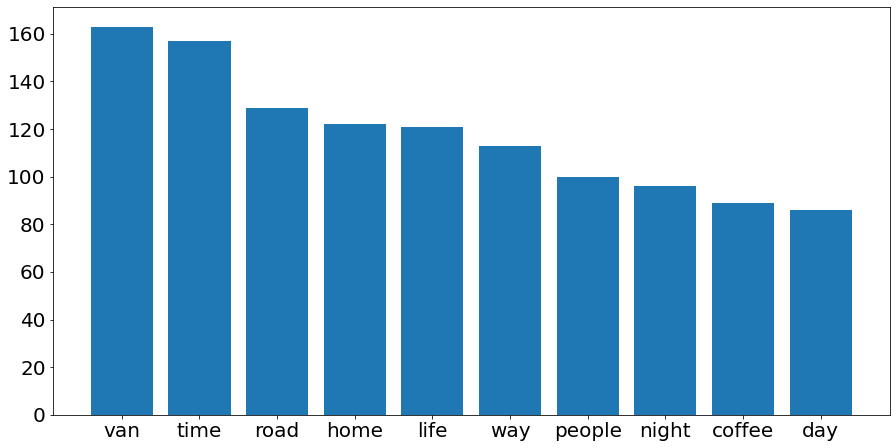

In [437]:
nouns = finalDf[finalDf["type"].str.contains("NN")] # all nouns
nouns = nouns.astype({"frequency": int})
nouns = nouns.sort_values("frequency", ascending = False) # clearly the pos_tag isn't perfect, because it thinks "van" is not a noun
# even though I didn't even know it could be anything else lol. going to repair above

# plot all of the most used nouns 
plt.bar(nouns["word"][0:10], nouns["frequency"][0:10])
plt.show()

In [358]:
posFrequency = finalDf.groupby(["type"]).count()["word"] # group by part of speech tags and count values for each
posFrequencyShort = pd.DataFrame((posFrequency[posFrequency >= 50])).reset_index()
posFrequencyShort.head(3)

,type,word
0,CD,107
1,JJ,1146
2,NN,1886


In [294]:
posTags = ["CD", "JJ", "NN", "NNS", "RB", "VBD", "VBG", "VBN", "VBP", "VBZ"]

In [295]:
# grab the html from the nltk website and convert to a dataframe as a translation table
codePage = requests.get("http://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html")
obj = pd.read_html(codePage.content) # convert the page to a string then run read_html
obj = obj[0] # isolate the df that we want
obj.columns = obj.iloc[0] # take the top row and convert it to the column index
trans = obj.drop(0) # drop the top row now
finalTrans = trans.rename(columns = {"Tag": "type", "Description": "word"})
finalTrans.head()

,Number,type,word
1,1.,CC,Coordinating conjunction
2,2.,CD,Cardinal number
3,3.,DT,Determiner
4,4.,EX,Existential there
5,5.,FW,Foreign word


In [296]:
def codeToWord(code, transTable, codeColumn = "type", wordColumn = "word"):
    row = transTable[transTable[codeColumn] == code]
    ser = row[wordColumn]
    word = (ser.values)[0]
    return(word)

In [297]:
words = [codeToWord(code, finalTrans) for code in posFrequencyShort["type"]]
if len(words) == len(posFrequencyShort):
    posFrequencyShort["transl"] = words
else:
    print("no")
    
posFrequencyShort

,type,word,transl
0,CD,107,Cardinal number
1,JJ,1146,Adjective
2,NN,1886,"Noun, singular or mass"
3,NNS,886,"Noun, plural"
4,RB,304,Adverb
5,VBD,502,"Verb, past tense"
6,VBG,463,"Verb, gerund or present participle"
7,VBN,218,"Verb, past participle"
8,VBP,392,"Verb, non-3rd person singular present"
9,VBZ,96,"Verb, 3rd person singular present"


In [298]:
# assigns umbrella parameters to create larger, higher-quality plots
plt.rcParams['figure.figsize'] = 15,7.5
plt.rcParams['font.size'] = 20

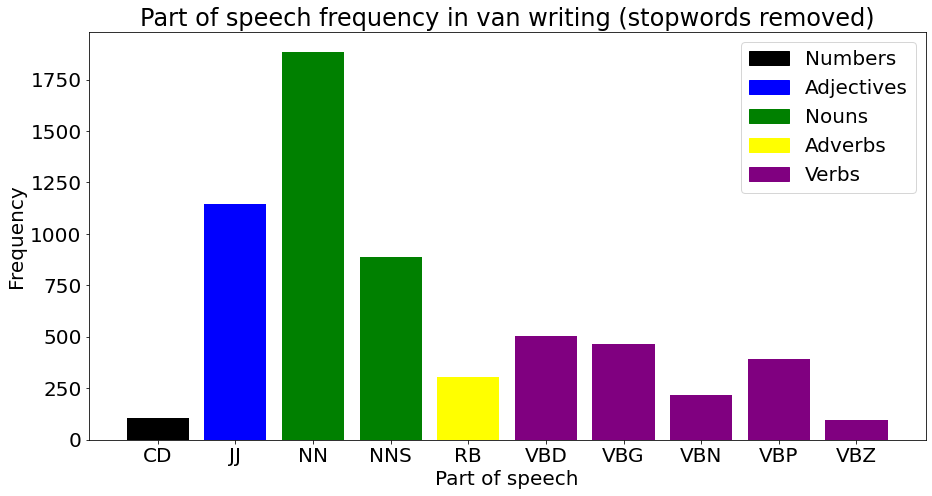

In [317]:
numberColor = "black"

adjectivalColor = "blue"
nounColor = "green"
adverbialColor = "yellow"
verbColor = "purple"

patches = [mpatches.Patch(color=numberColor, label="Numbers"), mpatches.Patch(color=adjectivalColor, label="Adjectives"),
           mpatches.Patch(color=nounColor, label="Nouns"),mpatches.Patch(color=adverbialColor, label="Adverbs"),
           mpatches.Patch(color=verbColor, label="Verbs")] # these patches allow us to create a legend for something
            # that has not been explicitly defined in the chart (see plt.legend below)
    
plt.bar(posFrequencyShort["type"], posFrequencyShort["word"], 
        color = [numberColor, adjectivalColor, nounColor, nounColor, adverbialColor, verbColor, verbColor, verbColor, verbColor,verbColor]) # this would be better
# if it was automatically grouped, but I haven't the time right now!!
plt.xlabel("Part of speech")
plt.ylabel("Frequency")
plt.title("Part of speech frequency in van writing (stopwords removed)")
plt.legend(handles=patches)
plt.show()

# TFIDF (term frequency-inverse document frequency)

In [7]:
# the following code creates a dictionary called documentFrequency which determines the total use of 
# individual/unique words across *all* documents
documentIndex = {} 
for sentIndex, sent in enumerate(salientWords):
    for word_index, word in enumerate(sent):
        try:
            # checks to see if there is an existing index and, if there is & the value of the 
            # sentence doesn't already exist, it adds the value
            documentIndex[word].add(sentIndex)
        except:
            # if there is not an existing index, it creates one and *then* adds the value
            documentIndex[word] = {sentIndex}

# documentIndex dictionary is indexed by the unique word. each entry is the sentence (document) #

documentFrequency = {}

for dictIndex, dictElement in enumerate(documentIndex):
    documentFrequency[dictElement] = len(documentIndex[dictElement]) # add the number
    # of documents that contain this index (word) to the new dict.
    
# documentFrequency is a dictionary containing 'unique_word': howManySentencesItOccursIn

In [8]:
# calculate total documents/sent
totalDocuments = len(salientWords)
print("There are %d total documents/sentences in the book"%(totalDocuments))

# calculate total words
wordLen = 0
for i,e in enumerate(salientWords):
    wordLen += len(e)
print("After the data was cleaned and processed there were %d total words remaining"%(wordLen))

There are 3101 total documents/sentences in the book
After the data was cleaned and processed there were 30970 total words remaining


In [9]:
termFrequencyLs = [] # create ls for term frequency (TF)
inverseDocFrequencyLs = [] # create ls for inverse document frequency (IDF)
tfidfLs = [] # create ls for term frequency-inverse document frequency (TF-IDF)
for sent_index, sent in enumerate(salientWords): # loop through each document
    # create a sep list for each document's stats
    tempTermFrequency = [] 
    tempInverseDocFrequency = []
    tempTfidf = []
    docLength = len(sent) # length of the current document (how many words in this sentence)
    counts = Counter(sent) # create a counter for unique values and their frequency per document
    for word_index, word in enumerate(sent): # iterate through each word in the current document
        frequencyInDoc = counts[word] # frequency of current word
        termFrequency = frequencyInDoc / docLength # term frequency for this word in this doc
        tempTermFrequency.append(termFrequency) 
        
        
        inverseDocFrequency = math.log((totalDocuments/(documentFrequency[word]))) # inverse doc
        # frequency for this word in this doc
        tempInverseDocFrequency.append(inverseDocFrequency)
        
        tfidf = (termFrequency * inverseDocFrequency) #tfidf for this word in this doc
        tempTfidf.append(tfidf)
    
    # append the list of the current document to the big-boy list
    termFrequencyLs.append(tempTermFrequency)
    inverseDocFrequencyLs.append(tempInverseDocFrequency)
    tfidfLs.append(tempTfidf)

### The code below returns lists of the top three (if available) words per sentence based on their TFIDF values.
It is assumed that the higher the TFIDF value, the more relevant it will be to that specific sentence, because the word
choice is salient to that specific sentence

In [323]:
## interesting. The following prints the top three TFIDF value for each document (i.e. sentence)
## SUPER INTERESTING. THE CODE BELOW GIVES A LOT OF MEANING IN THREE WORDS PER SENTENCE.
maximumIndexLs = []

for index, ls in enumerate(tfidfLs):
    #maximumIndex = np.argmax(ls)
    #maximumIndexLs.append(maximumIndex)
    #topThree = []
    n = 3
    topThreeIndeces = sorted(range(len(ls)), key = lambda sub: ls[sub])[-n:] # some crazy ass lambda function I found that grabs the indecies of the
    # three largest items. if someone can explain to me how this is working that would be lovely. all i know is that it works!
    # print(topThreeIndeces)
    maximumIndexLs.append(topThreeIndeces)
        
sentenceNum = []
wordOne = []
wordTwo = []
wordThree = []
if len(maximumIndexLs) == len(salientWords): # check to make sure we can iterate over these together
    for index, doc in enumerate(salientWords):
        #print("Sentence # %d: "%(index))
        indexLs = maximumIndexLs[index]
        if len(indexLs) ==3: 
            sentenceNum.append((index + 1))
            for j in range(3):
                tempWord = doc[(indexLs[j])]
                #print("Word %d: %s"%((j+1), tempWord))
                if j == 0:
                    wordOne.append(tempWord)
                elif j == 1:
                    wordTwo.append(tempWord)
                elif j == 2:
                    wordThree.append(tempWord)
        else:
            #print("Wrong number of maximums")
            sentenceNum.append((index+1))
            if len(indexLs) > 0:
                for j in range(len(indexLs)):
                    if j == 0:
                        wordOne.append(tempWord)
                    elif j == 1:
                        wordTwo.append(tempWord)
                        
else:
    print("Not same length.")

In [355]:
# the minimum tfidf values return almost the exact same proportions & order as a simple term frequency chart (see above),
# which makes complete sense
lsOfMinIndex = [sorted(range(len(ls)), key = lambda sub: ls[sub])[:1][0] for ls in tfidfLs]

lowestTfidf = []
if len(lsOfMinIndex) == len(salientWords):
    for index,sent in enumerate(salientWords):
        minIndex = lsOfMinIndex[index]
        word = sent[minIndex]
        lowestTfidf.append(word)
        
uniqeLow = uniqueArr(lowestTfidf)
uniqeLowDf = uniqueDf(uniqeLow)
uniqeLowDf.head(15)

,token,indexFirstTokenOccur,frequency
186,like,34,190
349,van,23,143
326,time,5,126
24,back,21,122
266,said,3,120
228,one,4,100
262,road,62,86
356,way,8,69
184,life,10,66
367,would,16,65


In [356]:
# make a dataframe with the top three words for each sentence
topThreeWords = pd.DataFrame(zip(sentenceNum,wordOne,wordTwo,wordThree), columns = ["sentenceNum", "wordOne", "wordTwo", "wordThree"])
topThreeWords[200:205]

,sentenceNum,wordOne,wordTwo,wordThree
200,201,spoke,born,bleeding
201,202,let,military,convincing
202,203,wisdom,bench,salvation
203,204,idaho,ear,bible
204,205,school,whispered,times


In [318]:
"""
replace with van.getPointers()

"""
# create a set of random pointers to filter out the word sets
random.seed(120)
pointers = []

for i in range(10):
    ptr = random.randint(0, len(sentenceNum))
    pointers.append(ptr)
    
print(pointers)

[2109, 1015, 772, 2602, 3005, 2415, 2748, 1894, 373, 1290]


In [85]:
# filter out the df according to the pointer and the length of sentences. append each df to a list
length = 3
sets = []

for index, ptr in enumerate(pointers):
    cap = ptr + length # cap is the top index in DataFrame[ptr:cap]
    tempDf = topThreeWords[ptr:cap]
    sets.append(tempDf)
    filePath = "randomSamples/randomSet" + str(index) + ".csv"
    tempDf.to_csv(filePath)
     
sets[2] # one is interestin

,sentenceNum,wordOne,wordTwo,wordThree
772,773,choice,simultameous,wants
773,774,wherever,crazy,jonathan
774,775,home,body,growing


In [ ]:
def getWordsFromPtrs(lsOfPtrs, numWords):
    sets = []
    
    for index,ptr in enumerate(lsOfPtrs):
        cap = ptr + numWords
        cap = ptr + length # cap is the top index in DataFrame[ptr:cap]
        tempDf = topThreeWords[ptr:cap]
        sets.append(tempDf)
        filePath = "randomSamples/randomSet" + str(index) + ".csv"
        tempDf.to_csv(filePath)
       
    return(sets)